In [1]:
!nvidia-smi
%matplotlib inline

Thu Oct 16 23:59:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:31:00.0 Off |                    0 |
| N/A   30C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
from helper_functions_testing import (
    batch_generate_responses_qwen3,
    get_judgments_from_responses,
    run_experiment,
    retrieve_results,
    prepare_test_prompts,
    obtain_results_without)
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import pandas as pd
import json
import re
import numpy as np
from typing import List, Optional, Dict, Any
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import torch

In [4]:
import os
print("HF_HOME:", os.environ.get("HF_HOME"))
print("HF_DATASETS_CACHE:", os.environ.get("HF_DATASETS_CACHE"))
print("HF_HUB_CACHE:", os.environ.get("HF_HUB_CACHE"))
os.environ["HF_HUB_DISABLE_XET"] = "1"
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"

# 可选：确保没被错误地关掉进度条
os.environ.pop("HF_HUB_DISABLE_PROGRESS_BARS", None)

HF_HOME: /scratch-local/yhuang/huggingface_cache
HF_DATASETS_CACHE: /scratch-local/yhuang/huggingface_cache/datasets
HF_HUB_CACHE: /scratch-local/yhuang/huggingface_cache/hub


### Loading verified examples (previously ICLS)

In [5]:
verified_examples = "../Data/in-context learning set (ICLS).csv"
df_verified_examples = pd.read_csv(verified_examples)

### Qwen3-4B (basic UND-FS prompt)

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM
Qwen3_4B = "Qwen/Qwen3-4B"
tokenizer = AutoTokenizer.from_pretrained(Qwen3_4B, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(Qwen3_4B)
# 将模型移到可用设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

cuda


In [9]:
system_prompt = """
You are an expert analyst. Your task is to analyze and determine whether an input user query is "fully specified" or "underspecified".

"""

task_FS_UND = """
Analyze the following input user query:

{"query": "TARGET"}

Please provide your analysis in the following JSON format:

{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}
"""

In [8]:
test_prompts = prepare_test_prompts(df_verified_examples, task_FS_UND)
print(test_prompts[0])

Start preparing prompts...
# Testing data points: 150
Generation complete: 150 prompts
Average prompt length: 331 bytes (~82 tokens)

Analyze the following input user query:

{"query": "When was the first world war broke out?"}

Please provide your analysis in the following JSON format:

{"query": "When was the first world war broke out?", "reasoning": "[YOUR_DETAILED_REASONING]", "judgment": "[fully specified/underspecified]"}



In [9]:
test_df = run_experiment(tokenizer, model, test_prompts, system_prompt, df_verified_examples)
test_df

100%|██████████| 30/30 [16:32<00:00, 33.07s/it]


,Unnamed: 0,request,gold_judgment,direct_source,category,reasoning,original_annotation,thinking,model_response,model_pred
0,1118,When was the first world war broke out?,underspecified,AmbigNQ,Undetermined perspective or granularity,The phrase “broke out” can be interpreted from...,"{""annotations"": [{""type"": ""multipleQAs"", ""qaPa...","<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""When was the first world war br...",fully specified
1,5585,Who sings the song i will try to fix you?,underspecified,AmbigNQ,Undetermined perspective or granularity,The question allows multiple granularities: it...,"{""annotations"": [{""type"": ""multipleQAs"", ""qaPa...","<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""Who sings the song i will try t...",underspecified
2,9330,Who is the head of the nation in india?,underspecified,AmbigNQ,Undetermined perspective or granularity,The question can refer to the role or title of...,"{""annotations"": [{""type"": ""multipleQAs"", ""qaPa...","<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""Who is the head of the nation i...",fully specified
3,9602,Moss is an example of which type of plant?,underspecified,AmbigNQ,Undetermined perspective or granularity,The term “type” can refer to different taxonom...,"{""annotations"": [{""type"": ""multipleQAs"", ""qaPa...","<think>\nOkay, let's tackle this query. The us...","{\n ""query"": ""Moss is an example of which typ...",fully specified
4,4145,How long can you serve in the house?,underspecified,AmbigNQ,"Undetermined lexicons or references, Undetermi...",The term “house” is referentially ambiguous be...,"{""annotations"": [{""type"": ""multipleQAs"", ""qaPa...","<think>\nOkay, let's see. The user asked, ""How...","{\n ""query"": ""How long can you serve in the h...",underspecified
...,...,...,...,...,...,...,...,...,...,...
145,1213,Give me a bulleted list of the 5 highest mount...,fully specified,CLAMBER,fully specified,This question is fully specified because it re...,NaN,"<think>\nOkay, let's see. The user wants a bul...","{\n ""query"": ""Give me a bulleted list of the ...",fully specified
146,2274,Who is the author of the novel Taipei by Tao Lin?,fully specified,CLAMBER,fully specified,This question is fully specified because it as...,NaN,"<think>\nOkay, let's see. The user is asking, ...","{\n ""query"": ""Who is the author of the novel ...",fully specified
147,356,What's the average body length of Brania russe...,fully specified,CLAMBER,fully specified,This question is fully specified because it as...,NaN,"<think>\nOkay, let me try to figure out if thi...","{\n ""query"": ""What's the average body length ...",fully specified
148,294,Is Bolusia capensis a unicellular organism in ...,fully specified,CLAMBER,fully specified,This question is fully specified because it as...,NaN,"<think>\nOkay, let's see. The user is asking i...","{\n ""query"": ""Is Bolusia capensis a unicellul...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.64      0.75      0.69        51
 underspecified       0.86      0.79      0.82        99

       accuracy                           0.77       150
      macro avg       0.75      0.77      0.76       150
   weighted avg       0.78      0.77      0.78       150



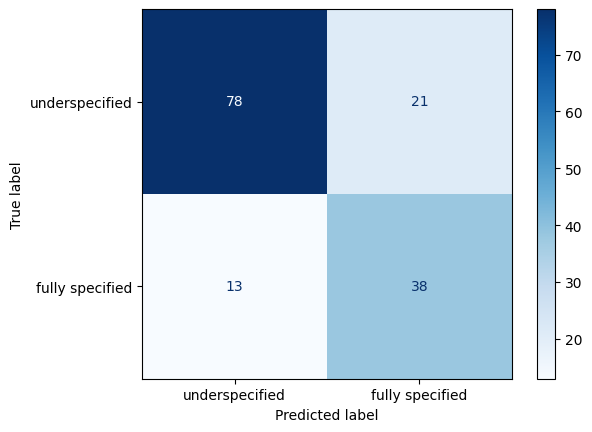

In [10]:
retrieve_results(test_df, "Qwen3_4B_verified_test")

### Qwen3-4B (DEF prompt)

In [7]:
definitions_and_detailed_instructions = """
In what follows, I'll give you detailed definitions of "underspecified" and "fully specified" queries.

For "underspecified" queries, they belong to 4 main categories:

- **Missing necessary components**: There is a strong perception that for at least one expression within the query, a commonly expected component conceptually tied to it is missing, thus its semantic interpretation is left with an unfilled slot. As a result, the meaning of the whole query is underspecified.

- **Undetermined lexicons or references**: The query contains at least one expression of lexical or referential ambiguity. For this lexical or referential ambiguous expression,  multiple same-level entities or concepts can be mapped to it and serve as potential lexical entries or referents. It’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

- **Undetermined perspective or granularity**: The query contains at least one expression where the general meaning is in place, but its specific interpretation can still vary based on different perspectives or granularities adopted. Multiple interpretations of different levels or natures are plausible for such an expression, and it’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

- **Undetermined standard or preference**: The query contains at least one expression where the general meaning is in place, but its specific interpretation is vague due to unspecified contextual standards or subjective criteria. A wide range of fine-grained interpretations is possible according to contextual or subjective needs, and it’s impossible to fully determine which one is intended based on the provided content. As a result, the meaning of the whole query is underspecified.

There is only one same-name category of "fully specified" queries, defined as follows:

- **fully specified**: The given query is totally clear and definitive, and it doesn't belong to any provided category of "underspecified" queries.


"""

task_text = """

When analyzing a given query, think step by step in an explicit way:

First, provide "reasoning" regarding whether it belongs to any of the provided categories of "underspecified" queries or the category of "fully specified" queries.

Second, assign a "category" to it. It can belong to multiple categories of "underspecified" at the same time, but categories of "underspecified" and the category of "fully specified" are mutual-exclusive.

Lastly, based on the "category" assigned, determine a "judgment" on whether it is "underspecified" or "fully specified". Categories of "underspecified" can only lead to a "underspecified" judgment, while the category of "fully specified" can only lead to a "fully specified" judgment.

Now analyze the following query:

{"query": "TARGET"}

Think step by step as illustrated and provide your analysis in the following JSON format:
{"query": "TARGET", "reasoning": "[YOUR_DETAILED_REASONING]", "category": "[CATEGORY]", "judgment": "[fully specified/underspecified]"}
"""

In [8]:
test_prompts_DEF = prepare_test_prompts(df_verified_examples, task_text, instruction_text=definitions_and_detailed_instructions)
print(test_prompts_DEF[0])

Start preparing prompts...
# Testing data points: 150
Generation complete: 150 prompts
Average prompt length: 3,242 bytes (~810 tokens)

In what follows, I'll give you detailed definitions of "underspecified" and "fully specified" queries.

For "underspecified" queries, they belong to 4 main categories:

- **Missing necessary components**: There is a strong perception that for at least one expression within the query, a commonly expected component conceptually tied to it is missing, thus its semantic interpretation is left with an unfilled slot. As a result, the meaning of the whole query is underspecified.

- **Undetermined lexicons or references**: The query contains at least one expression of lexical or referential ambiguity. For this lexical or referential ambiguous expression,  multiple same-level entities or concepts can be mapped to it and serve as potential lexical entries or referents. It’s impossible to fully determine which one is intended based on the provided content. As a

In [10]:
DEF_test_df =  run_experiment(tokenizer, model, test_prompts_DEF, system_prompt, df_verified_examples)
DEF_test_df

100%|██████████| 30/30 [27:19<00:00, 54.64s/it]


,Unnamed: 0,request,gold_judgment,direct_source,category,reasoning,original_annotation,thinking,model_response,model_pred
0,1118,When was the first world war broke out?,underspecified,AmbigNQ,Undetermined perspective or granularity,The phrase “broke out” can be interpreted from...,"{""annotations"": [{""type"": ""multipleQAs"", ""qaPa...","<think>\nOkay, let's tackle this query: ""When ...","{\n ""query"": ""When was the first world war br...",fully specified
1,5585,Who sings the song i will try to fix you?,underspecified,AmbigNQ,Undetermined perspective or granularity,The question allows multiple granularities: it...,"{""annotations"": [{""type"": ""multipleQAs"", ""qaPa...","<think>\nOkay, let's tackle this query: ""Who s...","{\n ""query"": ""Who sings the song i will try t...",fully specified
2,9330,Who is the head of the nation in india?,underspecified,AmbigNQ,Undetermined perspective or granularity,The question can refer to the role or title of...,"{""annotations"": [{""type"": ""multipleQAs"", ""qaPa...","<think>\nOkay, let's tackle this query: ""Who i...","{\n ""query"": ""Who is the head of the nation...",fully specified
3,9602,Moss is an example of which type of plant?,underspecified,AmbigNQ,Undetermined perspective or granularity,The term “type” can refer to different taxonom...,"{""annotations"": [{""type"": ""multipleQAs"", ""qaPa...","<think>\nOkay, let's tackle this query: ""Moss ...","{\n ""query"": ""Moss is an example of which typ...",fully specified
4,4145,How long can you serve in the house?,underspecified,AmbigNQ,"Undetermined lexicons or references, Undetermi...",The term “house” is referentially ambiguous be...,"{""annotations"": [{""type"": ""multipleQAs"", ""qaPa...","<think>\nOkay, let's tackle this query: ""How l...","{\n ""query"": ""How long can you serve in the h...",underspecified
...,...,...,...,...,...,...,...,...,...,...
145,1213,Give me a bulleted list of the 5 highest mount...,fully specified,CLAMBER,fully specified,This question is fully specified because it re...,NaN,"<think>\nOkay, let's tackle this query analysi...","{\n ""query"": ""Give me a bulleted list of the ...",fully specified
146,2274,Who is the author of the novel Taipei by Tao Lin?,fully specified,CLAMBER,fully specified,This question is fully specified because it as...,NaN,"<think>\nOkay, let's tackle this query: ""Who i...","{\n ""query"": ""Who is the author of the nove...",fully specified
147,356,What's the average body length of Brania russe...,fully specified,CLAMBER,fully specified,This question is fully specified because it as...,NaN,"<think>\nOkay, let me try to figure out if the...","{\n ""query"": ""What's the average body length ...",fully specified
148,294,Is Bolusia capensis a unicellular organism in ...,fully specified,CLAMBER,fully specified,This question is fully specified because it as...,NaN,"<think>\nOkay, let's tackle this query: ""Is Bo...","{\n ""query"": ""Is Bolusia capensis a unicellul...",fully specified


No error found, directly process the data.
                 precision    recall  f1-score   support

fully specified       0.48      0.78      0.60        51
 underspecified       0.84      0.57      0.67        99

       accuracy                           0.64       150
      macro avg       0.66      0.67      0.64       150
   weighted avg       0.72      0.64      0.65       150



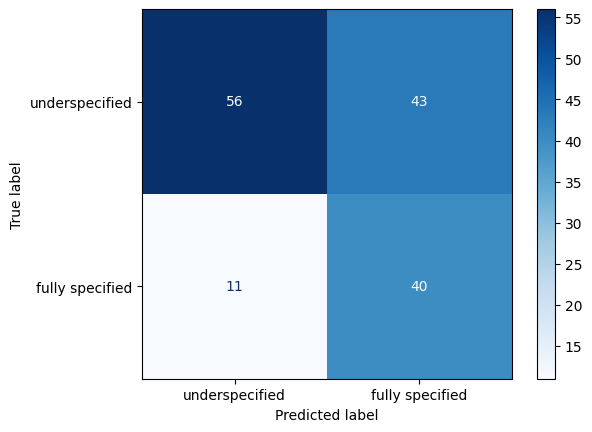

In [12]:
retrieve_results(DEF_test_df, "Qwen3_4B_verified_test_DEF")